# All oscillation analysis

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import collections
import itertools
from collections import defaultdict
from itertools import combinations

In [3]:
os.environ["SPECTRAL_CONNECTIVITY_ENABLE_GPU"] = "true"
import cupy as cp

In [4]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats


In [5]:
import matplotlib
import matplotlib.pyplot as plt

In [6]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [7]:
from scipy.signal import butter, filtfilt, hilbert

# Functions

In [8]:
def generate_pairs(lst):
    """
    Generates all unique pairs from a list.

    Parameters:
    - lst (list): The list to generate pairs from.

    Returns:
    - list: A list of tuples, each containing a unique pair from the input list.
    """
    n = len(lst)
    return [(lst[i], lst[j]) for i in range(n) for j in range(i+1, n)]

In [9]:
def update_array_by_mask(array, mask, value=np.nan):
    """
    Update elements of an array specified by a mask with a given value.
    
    Parameters:
        array (np.ndarray): The original array to be modified.
        mask (np.ndarray): A boolean array of the same shape as `array`.
                           Elements of `array` corresponding to True in the `mask`
                           will be updated.
        value (scalar, optional): The value to assign to elements of `array` specified by `mask`.
                                  Default is np.nan.
    
    Returns:
        np.ndarray: A copy of `array` with the specified elements updated.
    """
    result = array.copy()  # Create a copy of the input array to modify
    result[mask] = value   # Apply the mask to update the designated elements
    return result

## Inputs & Data

Explanation of each input and where it comes from.

In [10]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

In [11]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000

In [12]:
zscore_threshold = 4
VOLTAGE_SCALING_VALUE = 0.195

In [13]:
FILTER_BAND = (0, 56)

In [14]:
OUTPUT_PREFIX = "rce_pilot_2_standard"

In [15]:
LFP_TRACES_DF = pd.read_pickle("../2024_11_14_add_spike_times/proc/{}_02_lfp_traces_and_spikes.pkl".format(OUTPUT_PREFIX))


In [16]:
LFP_TRACES_DF.shape

(4, 28)

## Preprocessing

In [17]:
original_trace_columns = [col for col in LFP_TRACES_DF.columns if "trace" in col]

In [18]:
original_trace_columns

['mPFC_lfp_trace',
 'MD_lfp_trace',
 'LH_lfp_trace',
 'BLA_lfp_trace',
 'vHPC_lfp_trace']

In [19]:
for col in original_trace_columns:
    print(col)
    LFP_TRACES_DF[col] = LFP_TRACES_DF[col].apply(lambda x: x.astype(np.float32) * VOLTAGE_SCALING_VALUE)

mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace


In [20]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,subject,...,mPFC_lfp_trace,MD_lfp_trace,LH_lfp_trace,BLA_lfp_trace,vHPC_lfp_trace,recording_name,spike_clusters,spike_times,neuron_average_fr,neuron_average_timestamps
0,2,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.2,1.2,...,"[-4.875, 25.544998, 36.27, 23.205, 31.784998, ...","[-12.089999, 19.5, 30.224998, 9.554999, 17.355...","[-12.674999, 14.82, 16.185, -0.78, 21.255, 41....","[-31.98, -24.375, -24.375, -35.295, -40.949997...","[-111.92999, -96.329994, -84.435, -91.454994, ...",20230616_111904_standard_comp_to_training_D4_s...,"[13, 43, 46, 67, 68, 120, 128, 133, 151, 193, ...","[[164503.0, 214157.0, 219948.0, 228496.0, 2542...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2000, 4000, 6000, 8000, 10000, 12000, 1400..."
1,2,20230616_111904_standard_comp_to_training_D4_s...,"[[109, 358], [3101, 3349], [5967, 6217], [8211...","[[422, 423], [425, 480], [480, 601], [869, 877...","[[36005, 36005], [36006, 36008], [36009, 36010...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.2,1.2,...,"[-4.875, 25.544998, 36.27, 23.205, 31.784998, ...","[-12.089999, 19.5, 30.224998, 9.554999, 17.355...","[-12.674999, 14.82, 16.185, -0.78, 21.255, 41....","[-31.98, -24.375, -24.375, -35.295, -40.949997...","[-111.92999, -96.329994, -84.435, -91.454994, ...",20230616_111904_standard_comp_to_training_D4_s...,"[13, 43, 46, 67, 68, 120, 128, 133, 151, 193, ...","[[164503.0, 214157.0, 219948.0, 228496.0, 2542...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2000, 4000, 6000, 8000, 10000, 12000, 1400..."
2,2,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.4,1.4,...,"[-16.38, -13.65, -0.97499996, 17.16, 30.81, 32...","[40.17, 62.789997, 76.049995, 78.78, 107.835, ...","[1.7549999, 2.34, 9.165, 22.23, 41.34, 55.3799...","[18.33, 34.71, 52.065, 62.399998, 76.049995, 7...","[22.619999, 41.144997, 55.379997, 50.699997, 5...",20230616_111904_standard_comp_to_training_D4_s...,"[7, 23, 30, 53, 64, 73, 80, 90, 100, 102, 104,...","[[15575.0, 17748.0, 19503.0, 22868.0, 29093.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0,...","[0, 2000, 4000, 6000, 8000, 10000, 12000, 1400..."
3,2,20230616_111904_standard_comp_to_training_D4_s...,"[[109, 358], [3101, 3349], [5967, 6217], [8211...","[[422, 423], [425, 480], [480, 601], [869, 877...","[[36005, 36005], [36006, 36008], [36009, 36010...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.4,1.4,...,"[-16.38, -13.65, -0.97499996, 17.16, 30.81, 32...","[40.17, 62.789997, 76.049995, 78.78, 107.835, ...","[1.7549999, 2.34, 9.165, 22.23, 41.34, 55.3799...","[18.33, 34.71, 52.065, 62.399998, 76.049995, 7...","[22.619999, 41.144997, 55.379997, 50.699997, 5...",20230616_111904_standard_comp_to_training_D4_s...,"[7, 23, 30, 53, 64, 73, 80, 90, 100, 102, 104,...","[[15575.0, 17748.0, 19503.0, 22868.0, 29093.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0,...","[0, 2000, 4000, 6000, 8000, 10000, 12000, 1400..."


# Calculating modified zscore

`0.6745(xi – x̃) / MAD`

In [21]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_MAD".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: stats.median_abs_deviation(x))

mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace


In [22]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_modified_zscore".format(brain_region)
    MAD_column = "{}_lfp_MAD".format(brain_region)

    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF.apply(lambda x: 0.6745 * (x[col] - np.median(x[col])) / x[MAD_column], axis=1)

mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace


In [23]:
LFP_TRACES_DF[updated_column]

0    [-0.6733249, -0.579318, -0.5076376, -0.5499407...
1    [-0.6733249, -0.579318, -0.5076376, -0.5499407...
2    [0.28696907, 0.5199781, 0.69902724, 0.64016175...
3    [0.28696907, 0.5199781, 0.69902724, 0.64016175...
Name: vHPC_lfp_modified_zscore, dtype: object

## calculating root mean sequare

In [24]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_RMS".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: (x / np.sqrt(np.mean(x**2))).astype(np.float32))


mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace


In [25]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,subject,...,mPFC_lfp_modified_zscore,MD_lfp_modified_zscore,LH_lfp_modified_zscore,BLA_lfp_modified_zscore,vHPC_lfp_modified_zscore,mPFC_lfp_RMS,MD_lfp_RMS,LH_lfp_RMS,BLA_lfp_RMS,vHPC_lfp_RMS
0,2,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.2,1.2,...,"[-0.032214925, 0.28188056, 0.39261943, 0.25771...","[-0.15339799, 0.21205017, 0.33612207, 0.097001...","[-0.19106007, 0.21711373, 0.23737769, -0.01447...","[-0.3619817, -0.2742967, -0.2742967, -0.400203...","[-0.6733249, -0.579318, -0.5076376, -0.5499407...","[-0.046951603, 0.24602638, 0.34931993, 0.22348...","[-0.122624315, 0.19778116, 0.30656078, 0.09691...","[-0.11134413, 0.13018699, 0.1421779, -0.006851...","[-0.3240539, -0.24699232, -0.24699232, -0.3576...","[-0.6129893, -0.5275553, -0.46241182, -0.50085..."
1,2,20230616_111904_standard_comp_to_training_D4_s...,"[[109, 358], [3101, 3349], [5967, 6217], [8211...","[[422, 423], [425, 480], [480, 601], [869, 877...","[[36005, 36005], [36006, 36008], [36009, 36010...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.2,1.2,...,"[-0.032214925, 0.28188056, 0.39261943, 0.25771...","[-0.15339799, 0.21205017, 0.33612207, 0.097001...","[-0.19106007, 0.21711373, 0.23737769, -0.01447...","[-0.3619817, -0.2742967, -0.2742967, -0.400203...","[-0.6733249, -0.579318, -0.5076376, -0.5499407...","[-0.046951603, 0.24602638, 0.34931993, 0.22348...","[-0.122624315, 0.19778116, 0.30656078, 0.09691...","[-0.11134413, 0.13018699, 0.1421779, -0.006851...","[-0.3240539, -0.24699232, -0.24699232, -0.3576...","[-0.6129893, -0.5275553, -0.46241182, -0.50085..."
2,2,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.4,1.4,...,"[-0.26463637, -0.21945456, -0.009681818, 0.290...","[0.59531957, 0.9355022, 1.1349195, 1.1759762, ...","[0.023770925, 0.032685023, 0.13668282, 0.33576...","[0.17682835, 0.32995808, 0.4922027, 0.5888202,...","[0.28696907, 0.5199781, 0.69902724, 0.64016175...","[-0.25187972, -0.20989977, -0.014992841, 0.263...","[0.59839565, 0.9353563, 1.132885, 1.1735528, 1...","[0.026779197, 0.035705596, 0.13984692, 0.33920...","[0.16424781, 0.31102243, 0.46653366, 0.5591414...","[0.28243342, 0.5137366, 0.6914749, 0.6330404, ..."
3,2,20230616_111904_standard_comp_to_training_D4_s...,"[[109, 358], [3101, 3349], [5967, 6217], [8211...","[[422, 423], [425, 480], [480, 601], [869, 877...","[[36005, 36005], [36006, 36008], [36009, 36010...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.4,1.4,...,"[-0.26463637, -0.21945456, -0.009681818, 0.290...","[0.59531957, 0.9355022, 1.1349195, 1.1759762, ...","[0.023770925, 0.032685023, 0.13668282, 0.33576...","[0.17682835, 0.32995808, 0.4922027, 0.5888202,...","[0.28696907, 0.5199781, 0.69902724, 0.64016175...","[-0.25187972, -0.20989977, -0.014992841, 0.263...","[0.59839565, 0.9353563, 1.132885, 1.1735528, 1...","[0.026779197, 0.035705596, 0.13984692, 0.33920...","[0.16424781, 0.31102243, 0.46653366, 0.5591414...","[0.28243342, 0.5137366, 0.6914749, 0.6330404, ..."


## Filtering for zscore value

In [26]:
zscore_columns = [col for col in LFP_TRACES_DF.columns if "zscore" in col]

In [27]:
zscore_columns

['mPFC_lfp_modified_zscore',
 'MD_lfp_modified_zscore',
 'LH_lfp_modified_zscore',
 'BLA_lfp_modified_zscore',
 'vHPC_lfp_modified_zscore']

In [28]:
for col in zscore_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_mask".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: np.abs(x) >= zscore_threshold)

mPFC_lfp_modified_zscore
MD_lfp_modified_zscore
LH_lfp_modified_zscore
BLA_lfp_modified_zscore
vHPC_lfp_modified_zscore


In [29]:
LFP_TRACES_DF[updated_column].head()

0    [False, False, False, False, False, False, Fal...
1    [False, False, False, False, False, False, Fal...
2    [False, False, False, False, False, False, Fal...
3    [False, False, False, False, False, False, Fal...
Name: vHPC_lfp_mask, dtype: object

In [30]:
LFP_TRACES_DF[updated_column].iloc[0].shape

(3373973,)

In [31]:
sum(LFP_TRACES_DF[updated_column].iloc[0])

9076

- Filtering raw traces by zscore

In [32]:
LFP_TRACES_DF[col].head()

0    [-0.6733249, -0.579318, -0.5076376, -0.5499407...
1    [-0.6733249, -0.579318, -0.5076376, -0.5499407...
2    [0.28696907, 0.5199781, 0.69902724, 0.64016175...
3    [0.28696907, 0.5199781, 0.69902724, 0.64016175...
Name: vHPC_lfp_modified_zscore, dtype: object

In [33]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_trace_filtered".format(brain_region)    
    mask_column = "{}_lfp_mask".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF.apply(lambda x: update_array_by_mask(x[col], x[mask_column]), axis=1)

mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace


In [34]:
LFP_TRACES_DF[col].head()

0    [-111.92999, -96.329994, -84.435, -91.454994, ...
1    [-111.92999, -96.329994, -84.435, -91.454994, ...
2    [22.619999, 41.144997, 55.379997, 50.699997, 5...
3    [22.619999, 41.144997, 55.379997, 50.699997, 5...
Name: vHPC_lfp_trace, dtype: object

In [35]:
sum(np.isnan(LFP_TRACES_DF[col].iloc[0]))

0

- Calculating RMS of filtered signal

In [36]:
filtered_trace_column = [col for col in LFP_TRACES_DF if "lfp_trace_filtered" in col]

In [37]:
for col in filtered_trace_column:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_RMS_filtered".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: (x / np.sqrt(np.nanmean(x**2))).astype(np.float32))

mPFC_lfp_trace_filtered
MD_lfp_trace_filtered
LH_lfp_trace_filtered
BLA_lfp_trace_filtered
vHPC_lfp_trace_filtered


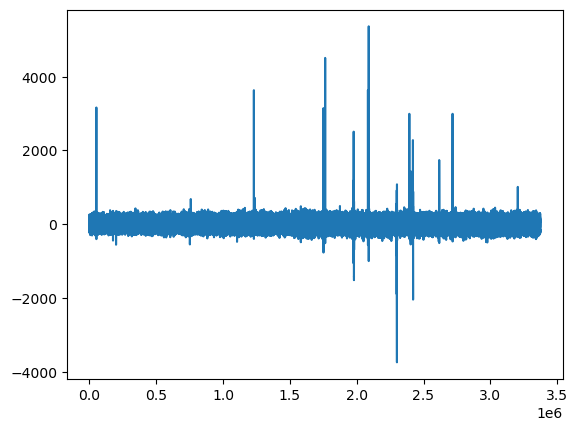

In [38]:
plt.plot(LFP_TRACES_DF[original_trace_columns[0]].iloc[0])

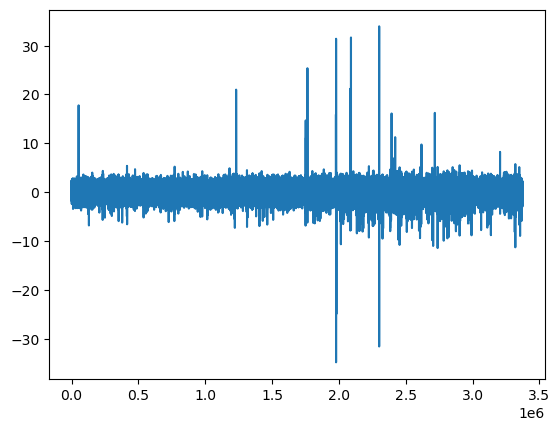

In [39]:
plt.plot(LFP_TRACES_DF["{}_lfp_RMS".format(brain_region)].iloc[0])

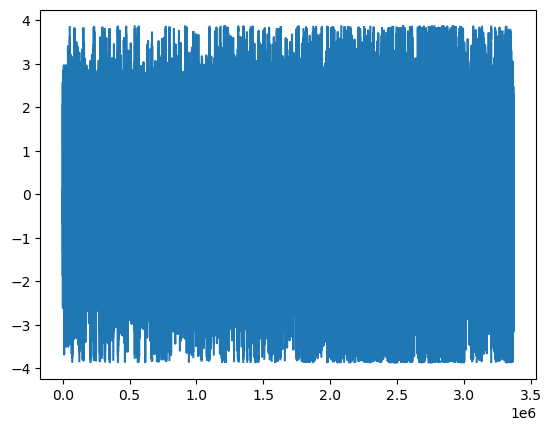

In [40]:
plt.plot(LFP_TRACES_DF["{}_lfp_RMS_filtered".format(brain_region)].iloc[0])

## Calculating phase of signals

- Filtering for theta and gamma

In [41]:
RMS_columns = [col for col in LFP_TRACES_DF if "RMS" in col and "filtered" not in col]

In [42]:
fs = 1000
order=4

In [43]:
freq_band = [4, 12]
b, a = butter(order, freq_band, fs=fs, btype='band')

In [44]:
for col in RMS_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_theta_band".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: filtfilt(b, a, x, padtype=None).astype(np.float32))

mPFC_lfp_RMS
MD_lfp_RMS
LH_lfp_RMS
BLA_lfp_RMS
vHPC_lfp_RMS


In [45]:
freq_band = [30, 50]
b, a = butter(order, freq_band, fs=fs, btype='band')

In [46]:
for col in RMS_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_gamma_band".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: filtfilt(b, a, x, padtype=None).astype(np.float32))

mPFC_lfp_RMS
MD_lfp_RMS
LH_lfp_RMS
BLA_lfp_RMS
vHPC_lfp_RMS


- Calculating the phase

In [47]:
band_columns = [col for col in LFP_TRACES_DF if "band" in col]

In [48]:
band_columns

['mPFC_theta_band',
 'MD_theta_band',
 'LH_theta_band',
 'BLA_theta_band',
 'vHPC_theta_band',
 'mPFC_gamma_band',
 'MD_gamma_band',
 'LH_gamma_band',
 'BLA_gamma_band',
 'vHPC_gamma_band']

In [49]:
for col in band_columns:
    print(col)
    brain_region = col.replace("_band", "")
    updated_column = "{}_phase".format(brain_region)
    print(updated_column)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: np.angle(hilbert(x), deg=False))

mPFC_theta_band
mPFC_theta_phase
MD_theta_band
MD_theta_phase
LH_theta_band
LH_theta_phase
BLA_theta_band
BLA_theta_phase
vHPC_theta_band
vHPC_theta_phase
mPFC_gamma_band
mPFC_gamma_phase
MD_gamma_band
MD_gamma_phase
LH_gamma_band
LH_gamma_phase
BLA_gamma_band
BLA_gamma_phase
vHPC_gamma_band
vHPC_gamma_phase


In [50]:
LFP_TRACES_DF[col]

0    [0.17008683, 0.15192373, 0.123936065, 0.087269...
1    [0.17008683, 0.15192373, 0.123936065, 0.087269...
2    [0.13008602, 0.13883811, 0.13782105, 0.1266129...
3    [0.13008602, 0.13883811, 0.13782105, 0.1266129...
Name: vHPC_gamma_band, dtype: object

# Dropping unused columns

In [51]:
list(LFP_TRACES_DF.columns)

['cohort',
 'session_dir',
 'tone_frames',
 'box_1_port_entry_frames',
 'box_2_port_entry_frames',
 'video_name',
 'session_path',
 'recording',
 'current_subject',
 'subject',
 'all_subjects',
 'first_timestamp',
 'last_timestamp',
 'video_timestamps',
 'tone_timestamps',
 'box_1_port_entry_timestamps',
 'box_2_port_entry_timestamps',
 'lfp_timestamps',
 'mPFC_lfp_trace',
 'MD_lfp_trace',
 'LH_lfp_trace',
 'BLA_lfp_trace',
 'vHPC_lfp_trace',
 'recording_name',
 'spike_clusters',
 'spike_times',
 'neuron_average_fr',
 'neuron_average_timestamps',
 'mPFC_lfp_MAD',
 'MD_lfp_MAD',
 'LH_lfp_MAD',
 'BLA_lfp_MAD',
 'vHPC_lfp_MAD',
 'mPFC_lfp_modified_zscore',
 'MD_lfp_modified_zscore',
 'LH_lfp_modified_zscore',
 'BLA_lfp_modified_zscore',
 'vHPC_lfp_modified_zscore',
 'mPFC_lfp_RMS',
 'MD_lfp_RMS',
 'LH_lfp_RMS',
 'BLA_lfp_RMS',
 'vHPC_lfp_RMS',
 'mPFC_lfp_mask',
 'MD_lfp_mask',
 'LH_lfp_mask',
 'BLA_lfp_mask',
 'vHPC_lfp_mask',
 'mPFC_lfp_trace_filtered',
 'MD_lfp_trace_filtered',
 'LH_lfp

In [52]:
dropping_columns = [col for col in LFP_TRACES_DF if ("MAD" in col or "modified_zscore" in col or "RMS" in col or "mask" in col or "trace_filtered" in col) and "RMS_filtered" not in col]




In [53]:
dropping_columns

['mPFC_lfp_MAD',
 'MD_lfp_MAD',
 'LH_lfp_MAD',
 'BLA_lfp_MAD',
 'vHPC_lfp_MAD',
 'mPFC_lfp_modified_zscore',
 'MD_lfp_modified_zscore',
 'LH_lfp_modified_zscore',
 'BLA_lfp_modified_zscore',
 'vHPC_lfp_modified_zscore',
 'mPFC_lfp_RMS',
 'MD_lfp_RMS',
 'LH_lfp_RMS',
 'BLA_lfp_RMS',
 'vHPC_lfp_RMS',
 'mPFC_lfp_mask',
 'MD_lfp_mask',
 'LH_lfp_mask',
 'BLA_lfp_mask',
 'vHPC_lfp_mask',
 'mPFC_lfp_trace_filtered',
 'MD_lfp_trace_filtered',
 'LH_lfp_trace_filtered',
 'BLA_lfp_trace_filtered',
 'vHPC_lfp_trace_filtered']

In [54]:
LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=dropping_columns, errors="ignore")

# Power Calcuation

- Getting the column name of all the traces

In [55]:
input_columns = [col for col in LFP_TRACES_DF.columns if "RMS" in col and "filtered" in col]

In [56]:
input_columns

['mPFC_lfp_RMS_filtered',
 'MD_lfp_RMS_filtered',
 'LH_lfp_RMS_filtered',
 'BLA_lfp_RMS_filtered',
 'vHPC_lfp_RMS_filtered']

In [57]:
for col in input_columns:
    print(col)
    LFP_TRACES_DF[col] = LFP_TRACES_DF[col].apply(lambda x: np.round(x.astype(np.float32), decimals=3))

mPFC_lfp_RMS_filtered
MD_lfp_RMS_filtered
LH_lfp_RMS_filtered
BLA_lfp_RMS_filtered
vHPC_lfp_RMS_filtered


- Calcuating the power at each frequency band

In [58]:
LFP_TRACES_DF[col].iloc[0]

array([-0.651, -0.56 , -0.491, ..., -0.219, -0.122, -0.046], dtype=float32)

In [59]:
for col in input_columns:
    # brain_region = col.split("_")[0]
    brain_region = col.replace("_lfp", "").replace("RMS_filtered", "").strip("_")
    print(brain_region)

    try:
        # Define column names
        frequencies_col = f"{brain_region}_power_frequencies"
        power_col = f"{brain_region}_power_all_frequencies_all_windows"

        index_to_multitaper = {}
        index_to_connectivity = {}
        index_to_frequencies = {}
        index_to_power = {}

        # Apply Multitaper function to the lfp_trace column
        for index, row in LFP_TRACES_DF.iterrows():
            print(index)
            index_to_multitaper[index] = Multitaper(
                    time_series=row[col], 
                    sampling_frequency=RESAMPLE_RATE, 
                    time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT,
                    time_window_duration=TIME_WINDOW_DURATION, 
                    time_window_step=TIME_WINDOW_STEP
                )
            index_to_connectivity[index] = Connectivity.from_multitaper(index_to_multitaper[index])
            index_to_frequencies[index] = index_to_connectivity[index].frequencies[FILTER_BAND[0]: FILTER_BAND[1]]
            index_to_power[index] = index_to_connectivity[index].power().squeeze()[:, FILTER_BAND[0]: FILTER_BAND[1]]

        LFP_TRACES_DF[frequencies_col] = LFP_TRACES_DF.index.to_series().map(index_to_frequencies)
        LFP_TRACES_DF[power_col] = LFP_TRACES_DF.index.to_series().map(index_to_power)
        LFP_TRACES_DF[power_col] = LFP_TRACES_DF[power_col].apply(lambda x: x.astype(np.float32))
    
    except Exception as e: 
        print(e)
        

mPFC
0
1
2
3
MD
0
1
2
3
LH
0
1
2
3
BLA
0
1
2
3
vHPC
0
1
2
3


- Getting the timestamps of the power

In [60]:
LFP_TRACES_DF["power_timestamps"] = LFP_TRACES_DF["lfp_timestamps"].apply(lambda x: x[(RESAMPLE_RATE//2):(-RESAMPLE_RATE//2):(RESAMPLE_RATE//2)])
# .iloc[0][500:-500:500].shape

- Making sure that the timestamps for power makes sense with shape and values

In [61]:
LFP_TRACES_DF["power_timestamps"].head().apply(lambda x: x.shape)

0    (6746,)
1    (6746,)
2    (6746,)
3    (6746,)
Name: power_timestamps, dtype: object

In [62]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_all_frequencies_all_windows" in col][0]].iloc[0].shape

(6746, 56)

In [63]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "lfp_timestamps" in col][0]].iloc[0]

array([       0,       20,       40, ..., 67479400, 67479420, 67479440])

In [64]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_timestamps" in col][0]].iloc[0]

array([   10000,    20000,    30000, ..., 67440000, 67450000, 67460000])

- Checking if the right frequencies are being used

In [65]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_frequencies" in col]].head()

,mPFC_power_frequencies,MD_power_frequencies,LH_power_frequencies,BLA_power_frequencies,vHPC_power_frequencies
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."


In [66]:
LFP_TRACES_DF["power_calculation_frequencies"] = LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_frequencies" in col][0]].copy()

- Dropping unnecessary columns

In [67]:
LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[col for col in LFP_TRACES_DF.columns if "power_frequencies" in col], errors="ignore")

In [68]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,subject,...,LH_gamma_phase,BLA_gamma_phase,vHPC_gamma_phase,mPFC_power_all_frequencies_all_windows,MD_power_all_frequencies_all_windows,LH_power_all_frequencies_all_windows,BLA_power_all_frequencies_all_windows,vHPC_power_all_frequencies_all_windows,power_timestamps,power_calculation_frequencies
0,2,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.2,1.2,...,"[-2.7160869, -1.8236631, -1.681745, -1.8968126...","[0.50826246, 1.3333526, 1.7000021, 1.9947182, ...","[-0.41710478, 0.41474962, 0.646071, 1.0493771,...","[[0.024098832, 0.009762518, 0.050892465, 0.041...","[[0.024836412, 0.011202014, 0.04129896, 0.0422...","[[0.026446192, 0.012803332, 0.038253866, 0.039...","[[0.018910084, 0.011932221, 0.046599995, 0.040...","[[0.037737194, 0.037598904, 0.04601228, 0.0198...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,2,20230616_111904_standard_comp_to_training_D4_s...,"[[109, 358], [3101, 3349], [5967, 6217], [8211...","[[422, 423], [425, 480], [480, 601], [869, 877...","[[36005, 36005], [36006, 36008], [36009, 36010...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.2,1.2,...,"[-2.7160869, -1.8236631, -1.681745, -1.8968126...","[0.50826246, 1.3333526, 1.7000021, 1.9947182, ...","[-0.41710478, 0.41474962, 0.646071, 1.0493771,...","[[0.024098832, 0.009762518, 0.050892465, 0.041...","[[0.024836412, 0.011202014, 0.04129896, 0.0422...","[[0.026446192, 0.012803332, 0.038253866, 0.039...","[[0.018910084, 0.011932221, 0.046599995, 0.040...","[[0.037737194, 0.037598904, 0.04601228, 0.0198...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,2,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.4,1.4,...,"[-1.9773532, -1.4975241, -1.1854475, -0.944297...","[2.4729097, 3.0763984, -3.1191442, -2.7943575,...","[-0.66944313, -0.050489824, 0.13606614, 0.5177...","[[0.0030704911, 0.0023163357, 0.0065870937, 0....","[[0.00068250974, 0.0044481694, 0.007730588, 0....","[[0.0026389644, 0.004899454, 0.008434624, 0.00...","[[0.005588406, 0.006961292, 0.008746286, 0.009...","[[0.0059722597, 0.0067153047, 0.011428782, 0.0...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,2,20230616_111904_standard_comp_to_training_D4_s...,"[[109, 358], [3101, 3349], [5967, 6217], [8211...","[[422, 423], [425, 480], [480, 601], [869, 877...","[[36005, 36005], [36006, 36008], [36009, 36010...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.4,1.4,...,"[-1.9773532, -1.4975241, -1.1854475, -0.944297...","[2.4729097, 3.0763984, -3.1191442, -2.7943575,...","[-0.66944313, -0.050489824, 0.13606614, 0.5177...","[[0.0030704911, 0.0023163357, 0.0065870937, 0....","[[0.00068250974, 0.0044481694, 0.007730588, 0....","[[0.0026389644, 0.004899454, 0.008434624, 0.00...","[[0.005588406, 0.006961292, 0.008746286, 0.009...","[[0.0059722597, 0.0067153047, 0.011428782, 0.0...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."


In [69]:
raise ValueError()

ValueError: 

## Coherence Calculation

- Getting the trace column pairs

In [ ]:
brain_region_pairs = generate_pairs(sorted(input_columns))
brain_region_pairs = sorted(brain_region_pairs)


In [ ]:
brain_region_pairs

## Coherece Calculation

- Calculating the coherence

In [ ]:
for region_1, region_2 in brain_region_pairs:
    # Define base name for pair
    pair_base_name = f"{region_1.split('_')[0]}_{region_2.split('_')[0]}"
    print(pair_base_name)

    try:
        # Define column names
        frequencies_col = f"{pair_base_name}_coherence_frequencies"
        coherence_col = f"{pair_base_name}_coherence_all_frequencies_all_windows"

        index_to_multitaper = {}
        index_to_connectivity = {}
        index_to_frequencies = {}
        index_to_coherence = {}

        for index, row in LFP_TRACES_DF.iterrows():
            index_to_multitaper[index] = Multitaper(
                time_series=np.array([row[region_1], row[region_2]]).T, 
                sampling_frequency=RESAMPLE_RATE, 
                time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT, 
                time_window_step=TIME_WINDOW_STEP, 
                time_window_duration=TIME_WINDOW_DURATION
            )
            print(index)
            index_to_connectivity[index] = Connectivity.from_multitaper(index_to_multitaper[index])
            index_to_frequencies[index] = index_to_connectivity[index].frequencies[FILTER_BAND[0]: FILTER_BAND[1]]
            index_to_coherence[index] = index_to_connectivity[index].coherence_magnitude()[:, FILTER_BAND[0]: FILTER_BAND[1], 0, 1]

        LFP_TRACES_DF[frequencies_col] = LFP_TRACES_DF.index.to_series().map(index_to_frequencies)
        LFP_TRACES_DF[coherence_col] = LFP_TRACES_DF.index.to_series().map(index_to_coherence)
        LFP_TRACES_DF[coherence_col] = LFP_TRACES_DF[coherence_col].apply(lambda x: x.astype(np.float32))

    except Exception as e: 
        print(e)

In [ ]:
LFP_TRACES_DF["BLA_LH_coherence_all_frequencies_all_windows"].iloc[0].shape

In [ ]:
LFP_TRACES_DF["BLA_LH_coherence_frequencies"].iloc[0]

In [ ]:
LFP_TRACES_DF.head()

- Getting the timestamps of the coherence

In [ ]:
LFP_TRACES_DF["coherence_timestamps"] = LFP_TRACES_DF["lfp_timestamps"].apply(lambda x: x[(RESAMPLE_RATE//2):(-RESAMPLE_RATE//2):(RESAMPLE_RATE//2)])


- Making sure that the timestamps for coherence makes sense with shape and values

In [ ]:
LFP_TRACES_DF["coherence_timestamps"].head().apply(lambda x: x.shape)

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_all_frequencies_all_windows" in col][0]].iloc[0].shape

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "lfp_timestamps" in col][0]].iloc[0]

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_timestamps" in col][0]].iloc[0]

- Checking if the right frequencies are being used

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_frequencies" in col]].head()

In [ ]:
LFP_TRACES_DF["coherence_calculation_frequencies"] = LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_frequencies" in col][0]].copy()

- Dropping unnecessary columns

In [ ]:
LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[col for col in LFP_TRACES_DF.columns if "coherence_frequencies" in col], errors="ignore")

In [ ]:
LFP_TRACES_DF.head()

# Calculate Granger's

In [ ]:
for region_1, region_2 in brain_region_pairs:
    # Define base name for pair
    region_1_base_name = region_1.split('_')[0]
    region_2_base_name = region_2.split('_')[0]

    pair_base_name = f"{region_1_base_name}_{region_2_base_name}"
    print(pair_base_name)

    try:
        # Define column names
        frequencies_col = f"{pair_base_name}_granger_frequencies"
        granger_1_2_col = f"{region_1_base_name}_{region_2_base_name}_granger_all_frequencies_all_windows"
        granger_2_1_col = f"{region_2_base_name}_{region_1_base_name}_granger_all_frequencies_all_windows"

        index_to_multitaper = {}
        index_to_connectivity = {}
        index_to_frequencies = {}
        index_to_granger_1_to_2 = {}
        index_to_granger_2_to_1 = {}

        
        for index, row in LFP_TRACES_DF.iterrows():
            # Apply Multitaper function
            index_to_multitaper[index] = Multitaper(
                    time_series=np.array([row[region_1], row[region_2]]).T, 
                    sampling_frequency=RESAMPLE_RATE, 
                    time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT, 
                    time_window_step=TIME_WINDOW_STEP, 
                    time_window_duration=TIME_WINDOW_DURATION
                )
            
            print(index)
            index_to_connectivity[index] = Connectivity.from_multitaper(index_to_multitaper[index])
            index_to_frequencies[index] = index_to_connectivity[index].frequencies[FILTER_BAND[0]: FILTER_BAND[1]]
            index_to_granger_1_to_2[index] = index_to_connectivity[index].pairwise_spectral_granger_prediction()[:, FILTER_BAND[0]: FILTER_BAND[1], 0, 1]
            index_to_granger_2_to_1[index] = index_to_connectivity[index].pairwise_spectral_granger_prediction()[:, FILTER_BAND[0]: FILTER_BAND[1], 1, 0]          
            

        LFP_TRACES_DF[frequencies_col] = LFP_TRACES_DF.index.to_series().map(index_to_frequencies)
        LFP_TRACES_DF[granger_1_2_col] = LFP_TRACES_DF.index.to_series().map(index_to_granger_1_to_2)
        LFP_TRACES_DF[granger_1_2_col] = LFP_TRACES_DF[granger_1_2_col].apply(lambda x: x.astype(np.float32))
        LFP_TRACES_DF[granger_2_1_col] = LFP_TRACES_DF.index.to_series().map(index_to_granger_2_to_1)
        LFP_TRACES_DF[granger_2_1_col] = LFP_TRACES_DF[granger_2_1_col].apply(lambda x: x.astype(np.float32))        
    
    except Exception as e: 
        print(e)

- Getting the timestamps of the granger

In [ ]:
LFP_TRACES_DF["granger_timestamps"] = LFP_TRACES_DF["lfp_timestamps"].apply(lambda x: x[(RESAMPLE_RATE//2):(-RESAMPLE_RATE//2):(RESAMPLE_RATE//2)])


- Making sure that the timestamps for granger makes sense with shape and values

In [ ]:
LFP_TRACES_DF["granger_timestamps"].head().apply(lambda x: x.shape)

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_all_frequencies_all_windows" in col][0]].iloc[0].shape

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "lfp_timestamps" in col][0]].iloc[0]

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_timestamps" in col][0]].iloc[0]

- Checking if the right frequencies are being used

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_frequencies" in col]].head()

In [ ]:
LFP_TRACES_DF["granger_calculation_frequencies"] = LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_frequencies" in col][0]].copy()

In [ ]:
LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[col for col in LFP_TRACES_DF.columns if "granger_frequencies" in col], errors="ignore")

In [ ]:
LFP_TRACES_DF.head()

# Saving to file

In [ ]:
LFP_TRACES_DF.head()

In [ ]:
LFP_TRACES_DF.columns

In [ ]:
LFP_TRACES_DF.to_pickle("./proc/{}_02_full_spectral.pkl".format(OUTPUT_PREFIX))

In [ ]:
raise ValueError()